In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
import xgboost
import os

In [2]:
dim = 10
import numpy as np

def m(x):
    y = 0
    k = 1
    if x[0] * x[1] >= 0:
        y += k * x[0] * x[1]
    else:
        y += - k * x[0] * x[1]
    if x[2] <= 0:
        y += x[2] * np.cos(np.pi * x[2])
    else:
        y += np.sin(np.pi * x[2])
    y += - x[3] - 0.5 * x[4] + 0.5 * x[5] + x[6]
    return y

def nabla_m(x):
    dim = len(x)
    d = np.zeros(dim)
    k = 1
    if x[0] * x[1] > 0:
        d[0] = k * x[1]
        d[1] = k * x[0]
    elif x[0] * x[1] == 0:
        d[0] = 0
        d[1] = 0
    else:
        d[0] = - k * x[1]
        d[1] = - k * x[0]
    if x[2] < 0 :
        d[2] = np.cos(np.pi * x[2]) - np.pi * x[2] *  np.sin(np.pi * x[2])
    elif x[2] == 0:
        d[2] = (np.pi + 1) / 2
    else:
        d[2] = np.pi * np.cos(np.pi * x[2])
    d[3:7] = [-1, -0.5, 0.5, 1]
    return d

def hessian_m(x):
    dim = len(x)
    h = np.zeros((dim, dim))
    k = 1
    if x[0] * x[1] > 0:
        h[0, 0] = 0
        h[0, 1] = k
        h[1, 0] = k
        h[1, 1] = 0
    elif x[0] * x[1] == 0:
        h[0, 0] = 0
        h[0, 1] = 0
        h[1, 0] = 0
        h[1, 1] = 0
    else:
        h[0, 0] = 0
        h[0, 1] = -k
        h[1, 0] = -k
        h[1, 1] = 0
    if x[2] < 0 :
        h[2, 2] = - np.pi * 2 * np.sin(np.pi * x[2]) - np.pi**2 * x[2] * np.cos(np.pi * x[2])
    elif x[2] == 0:
        h[2, 2] = 0
    else:
        h[2, 2] = - np.pi**2 * np.sin(np.pi * x[2])
    return h

def D_m3(x):
    if x[2] < 0:
        return np.pi**3*x[2] * np.sin(np.pi * x[2]) - np.pi**2 * 3 * np.cos(np.pi * x[2])
    elif x[2] == 0:
        return 0
    else:
        return -np.pi**3 * np.cos(np.pi * x[2])

def tr_hessian_m(x):
    return np.trace(hessian_m(x))

def pdf(x):
    return (2*np.pi)**(-5) * np.exp(-0.5 * np.linalg.norm(x, ord=2)**2)
def nabla_pdf(x):
    return -x * (2*np.pi)**(-5) * np.exp(-0.5 * np.linalg.norm(x, ord=2)**2)

def b_1(x):
    res = np.zeros(10)
    if x[0] * x[1] > 0:
        h12 = 1
    elif x[0] * x[1] == 0:
        h12 = 0
    else:
        h12 = -1

    if x[2] < 0:
        h3 = - np.pi * 2 * np.sin(np.pi * x[2]) - np.pi**2 * x[2] * np.cos(np.pi * x[2])
    elif x[2] == 0:
        h3 = 0
    else:
        h3 = - np.pi**2 * np.sin(np.pi * x[2])
        
    grad_f = nabla_pdf(x)
    res[0] = grad_f[0] * h3 + 2 * h12 * grad_f[1]
    res[1] = grad_f[1] * h3 + 2 * h12 * grad_f[0]
    res[2] = 3 * h3 * grad_f[2]
    for i in range(3, 10):
        res[i] = grad_f[i] * h3
    
    mu_2 = 1
    res -= mu_2 * tr_hessian_m(x) * nabla_pdf(x)

    return res
    

def K(x, sigma=1):
    w = np.linalg.norm(x, ord=2)
    return np.exp(-w ** 2 / 2 / sigma**2) / (2 * np.pi * sigma**2)**(dim/2)

In [3]:
std_value = 0.2
np.random.seed(seed=42)
model_train_set = pd.DataFrame(np.random.randn(100000, dim))
model_train_set['y'] = model_train_set.iloc[:, :10].T.apply(lambda x: m(x))
model_train_set['noise'] = np.random.randn(100000) * std_value
model_train_set['label'] = model_train_set['y'] + model_train_set['noise']

labeled_set = pd.DataFrame(np.random.randn(10000, dim))
labeled_set['y'] = labeled_set.iloc[:, :10].T.apply(lambda x: m(x))
labeled_set['noise'] = np.random.randn(10000) * std_value
labeled_set['label'] = labeled_set['y'] + labeled_set['noise']

unlabeled_set = pd.DataFrame(np.random.randn(10000*100, dim))
unlabeled_set['y'] = unlabeled_set.iloc[:, :10].T.apply(lambda x: m(x))

In [4]:
model_train_set['y'].std(), model_train_set['noise'].std(), model_train_set['label'].std()

(1.8885364044973483, 0.20123412730675014, 1.8991155454040096)

In [5]:
model = xgboost.XGBRegressor(n_estimators=300, max_depth=8, max_leaves=128, learning_rate=0.1, objective='reg:squarederror', tree_method='hist')
if 'model_2.json' not in os.listdir():
    model = model.fit(model_train_set.iloc[:, :10], model_train_set['label'])
    model.save_model('model_2.json')
else:
    model = xgboost.XGBRegressor()
    model.load_model('model_2.json') 
labeled_set['pred'] = model.predict(labeled_set.iloc[:, :10])
unlabeled_set['pred'] = model.predict(unlabeled_set.iloc[:, :10])

In [6]:
labeled_set['pred'] = model.predict(labeled_set.iloc[:, :10])
unlabeled_set['pred'] = model.predict(unlabeled_set.iloc[:, :10])

# Estimation and Inference

In [7]:
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from tqdm import tqdm

def process_target(i, target, labeled_set, unlabeled_set, h):
    labeled_set_leave_one_out = labeled_set.drop(i)
    target_X = target.iloc[:10]

    X = np.concatenate([
        np.ones((1, len(labeled_set_leave_one_out))),
        labeled_set_leave_one_out.iloc[:, :10].sub(target_X.values, axis=1).T.values
    ])
    Y = labeled_set_leave_one_out['label'].values.reshape(-1, 1)
    Y_F = labeled_set_leave_one_out['pred'].values.reshape(-1, 1)
    W = np.array([K(x[1:]/h) for x in X.T])

    tilde_X = np.concatenate([
        np.ones((1, len(unlabeled_set))),
        unlabeled_set.iloc[:, :10].sub(target_X.values, axis=1).T.values
    ])
    tilde_Y_F = unlabeled_set['pred'].values.reshape(-1, 1)
    tilde_W = np.array([K(x[1:]/h) for x in tilde_X.T])

    beta = np.linalg.inv((X * W) @ X.T) @ (X * W) @ Y
    inference = beta[0]

    beta_ppi = np.linalg.inv((tilde_X * tilde_W) @ tilde_X.T) @ (tilde_X * tilde_W) @ tilde_Y_F - \
               np.linalg.inv((X * W) @ X.T) @ (X * W) @ (Y_F - Y)
    inference_ppi = beta_ppi[0]
    
    return (inference[0], inference_ppi[0], target['label'], nabla_m(target_X), beta[1:].reshape(-1), beta_ppi[1:].reshape(-1))

In [8]:
for h in [0.5]:
    file_path = 'save_variable/'
    targets = labeled_set.sample(1000, random_state=42)
    result_df = pd.DataFrame(columns=['inference', 'inference_ppi', 'target'])
    grad_df_target = pd.DataFrame(columns=range(10))
    grad_df_infer = pd.DataFrame(columns=range(10))
    grad_df_infer_ppi = pd.DataFrame(columns=range(10))

    with ProcessPoolExecutor(max_workers=48) as executor:
        process_fn = partial(process_target, labeled_set=labeled_set, unlabeled_set=unlabeled_set, h=h)
        results = list(tqdm(executor.map(process_fn, targets.index, [target for _, target in targets.iterrows()]), total=len(targets)))

    for result in results:
        inference, inference_ppi, target_label, grad_target, grad_infer, grad_infer_ppi = result
        result_df.loc[len(result_df)] = [inference, inference_ppi, target_label]
        grad_df_target.loc[len(grad_df_target)] = grad_target
        grad_df_infer.loc[len(grad_df_infer)] = grad_infer
        grad_df_infer_ppi.loc[len(grad_df_infer_ppi)] = grad_infer_ppi

    result_df['inf_mse'] = (result_df['inference'] - result_df['target']) ** 2
    result_df['inf_ppi_mse'] = (result_df['inference_ppi'] - result_df['target']) ** 2
    result_df['pred'] = targets['pred'].values
    result_df['pred_mse'] = (result_df['pred'] - result_df['target']) ** 2

    print('h=', h, result_df['inf_mse'].mean(), result_df['inf_ppi_mse'].mean(), result_df['pred_mse'].mean())

100%|██████████| 1000/1000 [06:10<00:00,  2.70it/s]


h= 0.5 0.8848626763676315 0.33223322812704803 0.076655156293259


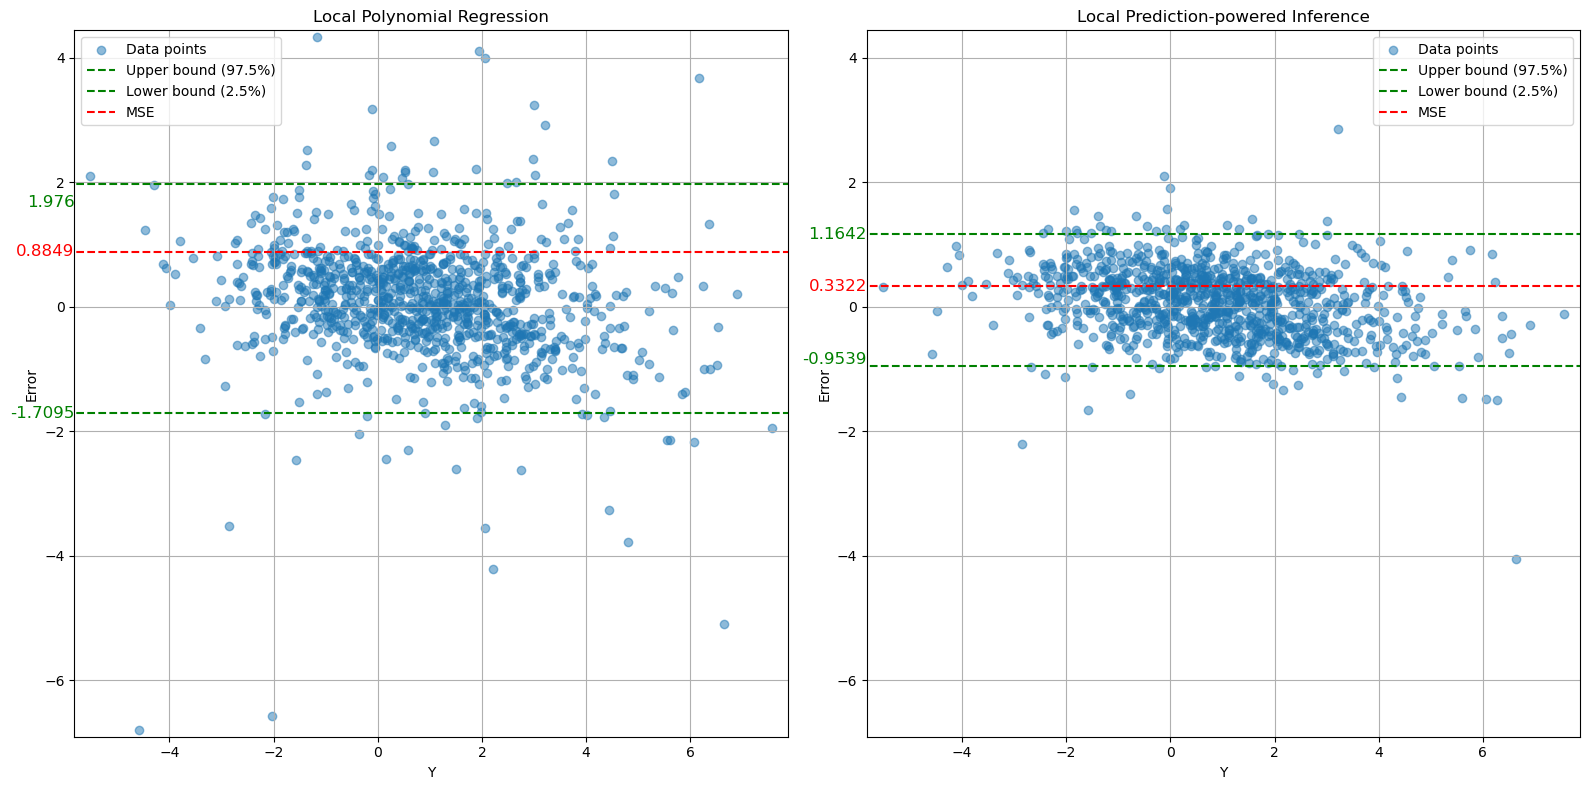

In [9]:

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
x = np.linspace(-10, 10, 100)
axes[0].scatter(result_df['target'], result_df['inference']-result_df['target'], alpha=0.5, label='Data points')
infer_upper = np.percentile(result_df['inference']-result_df['target'], 97.5)
infer_lower = np.percentile(result_df['inference']-result_df['target'], 2.5)
mse = np.mean((result_df['inference']-result_df['target'])**2)
axes[0].plot(x, infer_upper * np.ones(100), 'g--', label=f'Upper bound (97.5%)')
axes[0].plot(x, infer_lower * np.ones(100), 'g--', label=f'Lower bound (2.5%)')
axes[0].plot(x, mse * np.ones(100), 'r--', label=f'MSE')
axes[0].set_xlabel('Y')
axes[0].set_ylabel('Error')
axes[0].set_title('Local Polynomial Regression')
axes[0].legend()
axes[0].grid(True)

axes[1].scatter(result_df['target'], result_df['inference_ppi']-result_df['target'], alpha=0.5, label='Data points')
infer_ppi_upper = np.percentile(result_df['inference_ppi']-result_df['target'], 97.5)
infer_ppi_lower = np.percentile(result_df['inference_ppi']-result_df['target'], 2.5)
mse_ppi = np.mean((result_df['inference_ppi']-result_df['target'])**2)
axes[1].plot(x, infer_ppi_upper * np.ones(100), 'g--', label=f'Upper bound (97.5%)')
axes[1].plot(x, infer_ppi_lower * np.ones(100), 'g--', label=f'Lower bound (2.5%)')
axes[1].plot(x, mse_ppi * np.ones(100), 'r--', label=f'MSE')
axes[1].set_xlabel('Y')
axes[1].set_ylabel('Error')
axes[1].set_title('Local Prediction-powered Inference')
axes[1].legend()
axes[1].grid(True)

x_min = result_df['target'].min() - 0.3
x_max = result_df['target'].max() + 0.3
y_min = min((result_df['inference']-result_df['target']).min(), (result_df['inference_ppi']-result_df['target']).min()) - 0.1
y_max = max((result_df['inference']-result_df['target']).max(), (result_df['inference_ppi']-result_df['target']).max())  + 0.1
axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(y_min, y_max)
axes[1].set_xlim(x_min, x_max)
axes[1].set_ylim(y_min, y_max)
axes[0].annotate(str(round(mse,4)), (x_min, mse), arrowprops=dict(facecolor='black'), fontsize=12, color='red', ha='right', va='center')
axes[1].annotate(str(round(mse_ppi,4)), (x_min, mse_ppi), arrowprops=dict(facecolor='black'), fontsize=12, color='red', ha='right', va='center')
axes[0].annotate(str(round(infer_upper,4)), (x_min, infer_upper-0.3), arrowprops=dict(facecolor='black'), fontsize=12, color='green', ha='right', va='center')
axes[1].annotate(str(round(infer_ppi_upper,4)), (x_min, infer_ppi_upper), arrowprops=dict(facecolor='black'), fontsize=12, color='green', ha='right', va='center')
axes[0].annotate(str(round(infer_lower,4)), (x_min, infer_lower), arrowprops=dict(facecolor='black'), fontsize=12, color='green', ha='right', va='center')
axes[1].annotate(str(round(infer_ppi_lower,4)), (x_min, infer_ppi_lower+0.1), arrowprops=dict(facecolor='black'), fontsize=12, color='green', ha='right', va='center')

plt.tight_layout()
plt.show()

In [10]:
error = grad_df_infer - grad_df_target
error_ppi = grad_df_infer_ppi - grad_df_target

In [11]:
show_df = pd.DataFrame([((grad_df_infer - grad_df_target) ** 2).mean(),
                        ((grad_df_infer_ppi - grad_df_target) ** 2).mean()],
                        index=['inference', 'inference_ppi'])
show_df.loc['decay', :] = show_df.loc['inference_ppi', :] / show_df.loc['inference', :] - 1
show_df

,0,1,2,3,4,5,6,7,8,9
inference,0.490108,0.514765,4.424902,0.094104,0.102123,0.104738,0.103765,0.106377,0.097182,0.115270
inference_ppi,0.308533,0.305632,3.458422,0.026103,0.023740,0.024652,0.027941,0.024858,0.022303,0.023924
decay,-0.370481,-0.406270,-0.218418,-0.722614,-0.767532,-0.764636,-0.730732,-0.766319,-0.770505,-0.792450


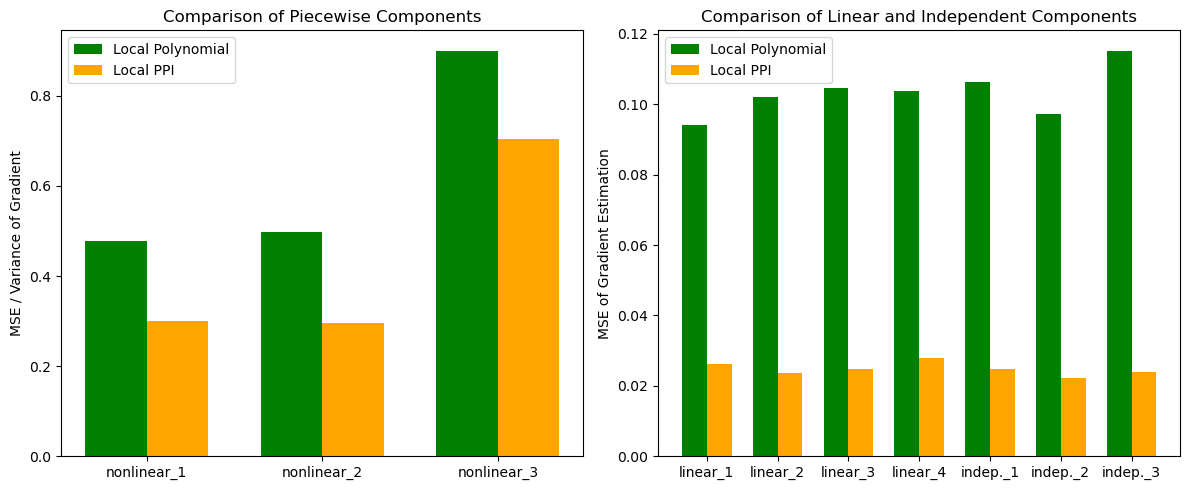

In [12]:
import numpy as np
import matplotlib.pyplot as plt

bar_width = 0.35
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


bars1 = axes[0].bar(np.arange(3), show_df.loc['inference', :2] / grad_df_target.var()[:3], bar_width, label='Local Polynomial', color='green')
bars2 = axes[0].bar(np.arange(3) + bar_width, show_df.loc['inference_ppi', :2] / grad_df_target.var()[:3], bar_width, label='Local PPI', color='orange')
axes[0].set_ylabel('MSE / Variance of Gradient')
axes[0].set_title('Comparison of Piecewise Components')
axes[0].set_xticks(np.arange(3) + bar_width / 2)
axes[0].set_xticklabels(['nonlinear_1', 'nonlinear_2', 'nonlinear_3'])
axes[0].legend()


bars3 = axes[1].bar(np.arange(7), show_df.loc['inference', 3:], bar_width, label='Local Polynomial', color='green')
bars4 = axes[1].bar(np.arange(7) + bar_width, show_df.loc['inference_ppi', 3:], bar_width, label='Local PPI', color='orange')
axes[1].set_ylabel('MSE of Gradient Estimation')
axes[1].set_title('Comparison of Linear and Independent Components')
axes[1].set_xticks(np.arange(7) + bar_width / 2)
axes[1].set_xticklabels(['linear_1', 'linear_2', 'linear_3', 'linear_4', 'indep._1', 'indep._2', 'indep._3'])
axes[1].legend()

plt.tight_layout()
# plt.savefig('simulation_gradient.png')
plt.show()

# Asymptotic Normality

In [13]:
def process_target_var(sub, j, labeled_set, unlabeled_set, h):
    target = labeled_set.iloc[j]
    target_X = target.iloc[:10]
    target_grad = nabla_m(target_X)
    target_y = target['label']
    record_df = pd.DataFrame(columns=np.arange(22), index=np.arange(10000))
    for i in tqdm(range(1000*sub, 1000*(sub+1))):
        labeled_set_leave_one_out = labeled_set.drop(j)
        labeled_set_leave_one_out = labeled_set_leave_one_out.sample(1000, random_state=42+i)
        unlabeled_set_sample = unlabeled_set.sample(1000*unlabel_scale, random_state=42+i)
        X = np.concatenate([
            np.ones((1, len(labeled_set_leave_one_out))),
            labeled_set_leave_one_out.iloc[:, :10].sub(target_X.values, axis=1).T.values
        ])
        Y = labeled_set_leave_one_out['label'].values.reshape(-1, 1)
        Y_F = labeled_set_leave_one_out['pred'].values.reshape(-1, 1)
        W = np.array([K(x[1:]/h) for x in X.T])

        tilde_X = np.concatenate([
            np.ones((1, len(unlabeled_set_sample))),
            unlabeled_set_sample.iloc[:, :10].sub(target_X.values, axis=1).T.values
        ])
        tilde_Y_F = unlabeled_set_sample['pred'].values.reshape(-1, 1)
        tilde_W = np.array([K(x[1:]/h) for x in tilde_X.T])

        beta = np.linalg.inv((X * W) @ X.T) @ (X * W) @ Y
        record_df.loc[i, :10] = beta.reshape(-1)

        beta_ppi = np.linalg.inv((tilde_X * tilde_W) @ tilde_X.T) @ (tilde_X * tilde_W) @ tilde_Y_F - \
                np.linalg.inv((X * W) @ X.T) @ (X * W) @ (Y_F - Y) 
        record_df.loc[i, 11:] = beta_ppi.reshape(-1)
    return target_y, target_grad, record_df

dfs_record = {}
dfs_target = {}

for arg in range(3):
    unlabel_scale = [10, 50, 200][arg]
    targets = labeled_set.sample(1, random_state=42)
    record_df_total = pd.DataFrame(columns=np.arange(22))
    target_df = pd.DataFrame(columns=np.arange(11))
    h = 0.5

    np.random.seed(42)
    label_index = np.random.randint(0, 10000)

    with ProcessPoolExecutor(max_workers=48) as executor:
        process_fn = partial(process_target_var, j=label_index, labeled_set=labeled_set, unlabeled_set=unlabeled_set, h=h)
        results = list(tqdm(executor.map(process_fn, range(10)), total=10))

    tmp_df = pd.DataFrame(columns=np.arange(22))

    for result in results:
        a, b, c = result
        tmp_df = pd.concat([tmp_df, c], axis=0)

    target_df = pd.DataFrame(columns=np.arange(11))
    target_df.loc[0] = np.concatenate([np.array([a]), b])

    dfs_record[unlabel_scale] = tmp_df
    dfs_target[unlabel_scale] = target_df


100%|██████████| 10/10 [28:41<00:00, 172.19s/it]


In [14]:
df1, df3, df5 = dfs_record[10], dfs_record[50], dfs_record[200]

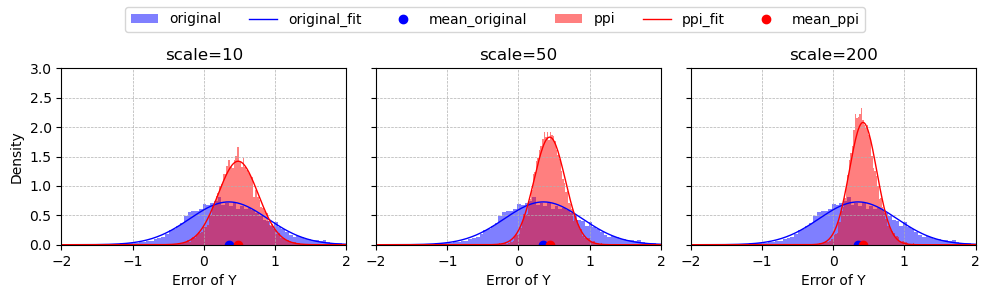

In [15]:
import matplotlib.pyplot as plt
from scipy.stats import norm
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

for i, ax in enumerate(axs.flat):
    df = [df1, df3, df5][i]
    targets = target_df.values
    res1 = (df - np.concatenate([target_df.values,target_df.values]).reshape(-1)).iloc[:, 0].dropna().values
    res2 = (df - np.concatenate([target_df.values,target_df.values]).reshape(-1)).iloc[:, 11].dropna().values

    ax.hist(res1, bins=100, color='b', density=True, alpha=0.5, label='original')
    mean1, std1 = np.mean(res1), np.std(res1)
    mean2, std2 = np.mean(res2), np.std(res2)
    xmin, xmax = plt.xlim()
    x = np.linspace(-2, 2, 300)
    p1 = norm.pdf(x, mean1, std1)
    p2 = norm.pdf(x, mean2, std2)
    ax.plot(x, p1, linewidth=1, color='b', label='original_fit')
    ax.plot(mean1, 0, 'bo', label='mean_original')
    ax.hist(res2, bins=100, color='r', density=True, alpha=0.5, label='ppi')
    ax.plot(x, p2, linewidth=1, color='r', label='ppi_fit')
    ax.plot(mean2, 0, 'ro', label='mean_ppi')
    ax.set_ylim([0, 3])
    ax.set_xlim([-2, 2])
    ax.set_title('scale={}'.format(str([10,50, 200, 500][i])))
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.set_xlabel('Error of Y')
    if i % 3 == 0:
        ax.set_ylabel('Density')
    else:
        ax.set_yticklabels([])
lines, labels = axs[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper center', ncol=6)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()
# plt.savefig("normal_value.png")

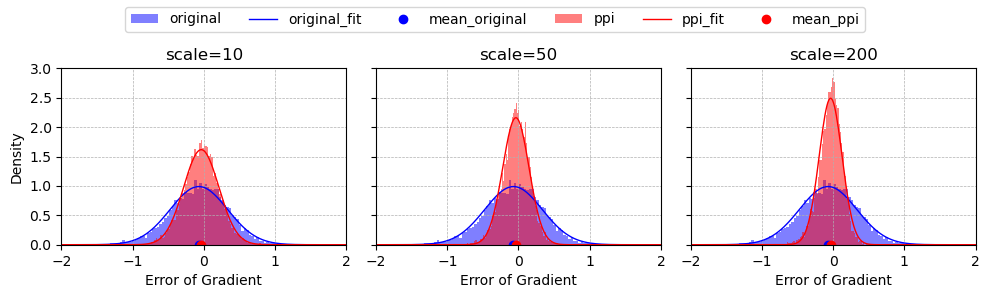

In [16]:
import matplotlib.pyplot as plt
from scipy.stats import norm
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

for i, ax in enumerate(axs.flat):
    df = [df1, df3, df5][i]
    targets = target_df.values
    res1 = (df - np.concatenate([target_df.values,target_df.values]).reshape(-1)).iloc[:, 4].dropna().values
    res2 = (df - np.concatenate([target_df.values,target_df.values]).reshape(-1)).iloc[:, 15].dropna().values

    ax.hist(res1, bins=100, color='b', density=True, alpha=0.5, label='original')
    mean1, std1 = np.mean(res1), np.std(res1)
    mean2, std2 = np.mean(res2), np.std(res2)
    xmin, xmax = plt.xlim()
    x = np.linspace(-2, 2, 300)
    p1 = norm.pdf(x, mean1, std1)
    p2 = norm.pdf(x, mean2, std2)
    ax.plot(x, p1, linewidth=1, color='b', label='original_fit')
    ax.plot(mean1, 0, 'bo', label='mean_original')
    ax.hist(res2, bins=100, color='r', density=True, alpha=0.5, label='ppi')
    ax.plot(x, p2, linewidth=1, color='r', label='ppi_fit')
    ax.plot(mean2, 0, 'ro', label='mean_ppi')
    ax.set_ylim([0, 3])
    ax.set_xlim([-2, 2])
    # ax.legend()
    ax.set_title('scale={}'.format(str([10,50, 200][i])))
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.set_xlabel('Error of Gradient')
    if i % 3 == 0:
        ax.set_ylabel('Density')
    else:
        ax.set_yticklabels([])
lines, labels = axs[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper center', ncol=6)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()
# plt.savefig("normal_gradient_1.png")

# Coverage Probability

In [17]:
def A_reverse(x, h):
    a = np.eye(11)
    a[0, 1:11] = - h / pdf(x) * nabla_pdf(x)
    a[1:11, 0] = - h / pdf(x) * nabla_pdf(x)
    a /= pdf(x)
    return a
def A(x, h):
    a = pdf(x) * np.eye(10)
    a[0, 1:11] = h * nabla_pdf(x)
    a[1:11, 0] = h * nabla_pdf(x)
    return a

In [18]:
def Var_ppi(x, s, h, n, N, sigma=0.2, p=10):
    Xs = s.iloc[:, :10].sub(x, axis=1).values
    Ws = np.array([K(tmp/h) for tmp in Xs])
    Xs = np.concatenate([np.ones((len(Xs), 1)), Xs/h], axis=1)
    res1 = n ** (-1) * Var_1(Xs, s, Ws)
    res2 = n ** (-1) * sigma**2 * Var_2(Xs, s, Ws) * 0
    res3 = N ** (-1) * Var_3(Xs, s, Ws)
    res = res1 + res2 + res3
    res = A_reverse(x, h) @ res @ A_reverse(x, h).T
    return res

def Var(x, s, h, n, sigma=0.2, p=10):
    Xs = s.iloc[:, :10].sub(x, axis=1).values
    Ws = np.array([K(tmp/h) for tmp in Xs])
    Xs = np.concatenate([np.ones((len(Xs), 1)), Xs/h], axis=1)
    res4 = n ** (-1) * Var_4(Xs, s, Ws)
    res2 = n ** (-1) * sigma**2 * Var_2(Xs, s, Ws) * 0
    res = res2 + res4
    res = A_reverse(x, h) @ res @ A_reverse(x, h).T
    return res

def Var_1(Xs, s, Ws):
    tmp_error = (s['pred'] - s['y']).values
    tmp = np.multiply(np.multiply(Xs, Ws.reshape(-1, 1)), tmp_error.reshape(-1, 1))
    return np.cov(tmp.T)

def Var_2(Xs, s, Ws):
    tmp = np.multiply(Xs, Ws.reshape(-1, 1))
    return tmp.T @ tmp / len(Ws)

def Var_3(Xs, s, Ws):
    tmp = np.multiply(np.multiply(Xs, Ws.reshape(-1, 1)), s['pred'].values.reshape(-1, 1))
    return np.cov(tmp.T)

def Var_4(Xs, s, Ws):
    tmp_error = (s['y']).values
    tmp = np.multiply(np.multiply(Xs, Ws.reshape(-1, 1)), tmp_error.reshape(-1, 1))
    return np.cov(tmp.T) 


In [19]:
def local_inference(target, labeled_set, unlabeled_set, h):
    target_X = target.iloc[:10]

    X = np.concatenate([
        np.ones((1, len(labeled_set))),
        labeled_set.iloc[:, :10].sub(target_X.values, axis=1).T.values
    ])
    Y = labeled_set['label'].values.reshape(-1, 1)
    Y_F = labeled_set['pred'].values.reshape(-1, 1)
    W = np.array([K(x[1:]/h) for x in X.T])

    tilde_X = np.concatenate([
        np.ones((1, len(unlabeled_set))),
        unlabeled_set.iloc[:, :10].sub(target_X.values, axis=1).T.values
    ])
    tilde_Y_F = unlabeled_set['pred'].values.reshape(-1, 1)
    tilde_W = np.array([K(x[1:]/h) for x in tilde_X.T])

    beta = np.linalg.inv((X * W) @ X.T) @ (X * W) @ Y
    inference = beta[0]

    beta_ppi = np.linalg.inv((tilde_X * tilde_W) @ tilde_X.T) @ (tilde_X * tilde_W) @ tilde_Y_F - \
               np.linalg.inv((X * W) @ X.T) @ (X * W) @ (Y_F - Y)
    inference_ppi = beta_ppi[0]
    
    return (inference[0], inference_ppi[0], target['y'], nabla_m(target_X), beta[1:].reshape(-1), beta_ppi[1:].reshape(-1))

In [20]:
target_points = labeled_set.sample(100, random_state=42)
h = 0.5
for n in [100, 200, 500, 1000, 2000]:
    target_point = labeled_set.iloc[1]
    record1 = []
    record2 = []

    for i in tqdm(range(1000)):
        sample_label = labeled_set.drop(1).sample(n, random_state=i+1)
        sample_unlabel = unlabeled_set.sample(100*n, random_state=i+2)
        infer, infer_ppi, target_y, target_grad, infer_grad, infer_ppi_grad = local_inference(target_point, sample_label, sample_unlabel, h)

        record1.append(infer)
        record2.append(infer_ppi)
    err = 0.5 * h**2 * tr_hessian_m(target_point.iloc[:10].values)
    print(n, (np.abs((record1 - target_y - err)) < 1.96 * np.std((record1))).sum() / len(record1), (np.abs((record2 - target_y  - err)) < 1.96 * np.std((record2))).sum() / len(record2), (np.abs((record2 - target_y - err)) < 1.96 * np.std((record1))).sum() / len(record2), np.std(record1), np.std(record2))


100%|██████████| 1000/1000 [01:53<00:00,  8.82it/s]


100 0.935 0.942 0.999 2.3669697245280097 0.9714671710099027


100%|██████████| 1000/1000 [03:10<00:00,  5.25it/s]


200 0.941 0.943 0.999 1.8830846646414123 0.8024532518494594


100%|██████████| 1000/1000 [07:04<00:00,  2.35it/s]


500 0.923 0.944 0.999 1.1632966228272401 0.5634227202471426


100%|██████████| 1000/1000 [13:27<00:00,  1.24it/s]


1000 0.942 0.941 1.0 1.0505057189974363 0.4950513204220562


100%|██████████| 1000/1000 [27:00<00:00,  1.62s/it]

2000 0.918 0.932 0.999 0.9223392717177862 0.454374685796728


In [21]:
target_points = labeled_set.sample(100, random_state=42)
h = 0.5
for n in [100, 200, 500, 1000, 2000]:
    target_point = labeled_set.iloc[1]
    record1 = []
    record2 = []

    for i in tqdm(range(1000)):
        sample_label = labeled_set.drop(1).sample(n, random_state=i+1)
        sample_unlabel = unlabeled_set.sample(100*n, random_state=i+2)
        infer, infer_ppi, target_y, target_grad, infer_grad, infer_ppi_grad = local_inference(target_point, sample_label, sample_unlabel, h)

        record1.append(infer)
        record2.append(infer_ppi)
    err = 0.5 * h**2 * tr_hessian_m(target_point.iloc[:10].values) * 0
    print(n, (np.abs((record1 - target_y - err)) < 1.96 * np.std((record1))).sum() / len(record1), (np.abs((record2 - target_y  - err)) < 1.96 * np.std((record2))).sum() / len(record2), (np.abs((record2 - target_y - err)) < 1.96 * np.std((record1))).sum() / len(record2), np.std(record1), np.std(record2))

100%|██████████| 1000/1000 [02:23<00:00,  6.95it/s]


100 0.928 0.921 0.999 2.3669697245280097 0.9714671710099027


100%|██████████| 1000/1000 [03:48<00:00,  4.39it/s]


200 0.929 0.931 0.999 1.8830846646414123 0.8024532518494594


100%|██████████| 1000/1000 [07:21<00:00,  2.27it/s]


500 0.881 0.889 0.999 1.1632966228272401 0.5634227202471426


100%|██████████| 1000/1000 [12:32<00:00,  1.33it/s]


1000 0.882 0.884 1.0 1.0505057189974363 0.4950513204220562


100%|██████████| 1000/1000 [24:06<00:00,  1.45s/it]

2000 0.868 0.911 0.999 0.9223392717177862 0.454374685796728
